In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm

In [2]:
operations = {
    "orf": "wellpos_cc_var_mad_outlier_featselect_sphering_harmony",
    "crispr": "wellpos_var_mad_int_featselect_harmony_PCA_corrected"
}

variable = "essentiality"
col_name = f"Metadata_{variable}"
col_name_in_metadata = "Metadata_dependency_probability"
output_df = pd.DataFrame()

In [3]:
# Read phenotypic activity

orf_phenotypic_activity_df = pd.read_csv(
    f"../03.retrieve-annotations/output/phenotypic-activity-{operations['orf']}.csv.gz"
)[["Metadata_JCP2022", "mean_average_precision", "below_corrected_p"]]

crispr_phenotypic_activity_df = pd.read_csv(
    f"../03.retrieve-annotations/output/phenotypic-activity-{operations['crispr']}.csv.gz"
)[["Metadata_JCP2022", "mean_average_precision", "below_corrected_p"]]

In [4]:
# Read metadata

orf_metadata_df = (
    pd.read_csv(
        "../00.download-and-process-annotations/output/orf_metadata.tsv.gz", sep="\t"
    )[["Metadata_JCP2022", col_name_in_metadata]]
    .assign(col=lambda x: np.where(x[col_name_in_metadata] > 0.75, "True", "False"))
    .rename(columns={"col": col_name})
)

crispr_metadata_df = (
    pd.read_csv(
        "../00.download-and-process-annotations/output/crispr_metadata.tsv.gz", sep="\t"
    )[["Metadata_JCP2022", col_name_in_metadata]]
    .assign(col=lambda x: np.where(x[col_name_in_metadata] > 0.75, "True", "False"))
    .rename(columns={"col": col_name})
)

In [5]:
orf_df = orf_phenotypic_activity_df.merge(
    orf_metadata_df, on="Metadata_JCP2022", how="inner"
).dropna(subset=[col_name])
crispr_df = crispr_phenotypic_activity_df.merge(
    crispr_metadata_df, on="Metadata_JCP2022", how="inner"
).dropna(subset=[col_name])

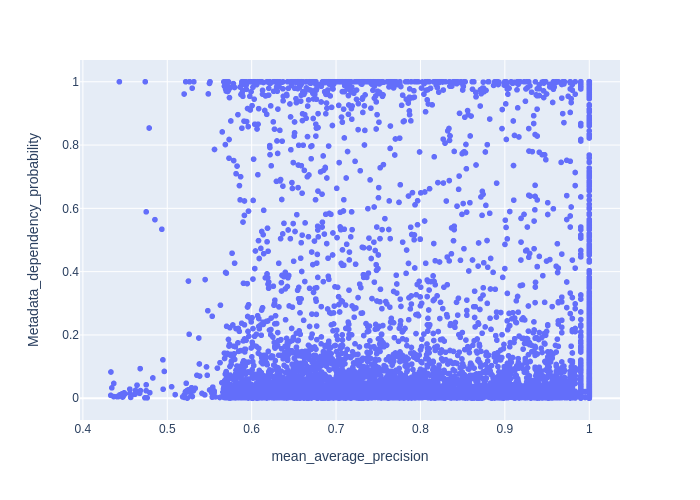

In [6]:
fig = px.scatter(
    orf_df.query("below_corrected_p==True"),
    x="mean_average_precision",
    y=f"{col_name_in_metadata}",
)

fig.show("png")

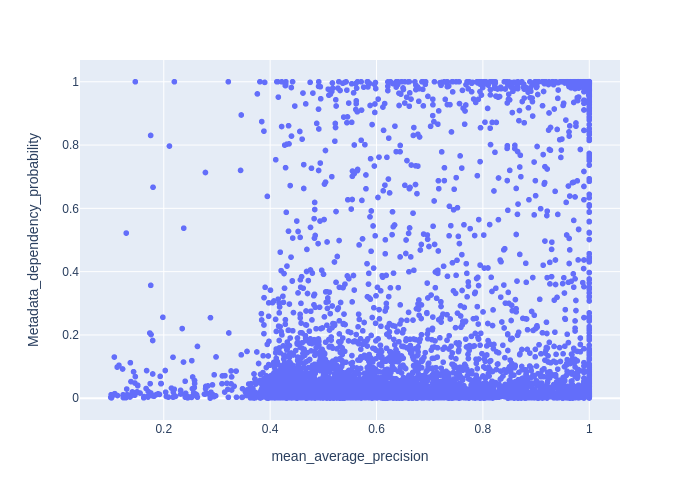

In [7]:
fig = px.scatter(
    crispr_df.query("below_corrected_p==True"),
    x="mean_average_precision",
    y=f"{col_name_in_metadata}",
)

fig.show("png")

Fisher's exact test ORF

In [8]:
table = sm.stats.Table.from_data(orf_df[["below_corrected_p", col_name]])
print(
    pd.DataFrame(
        table.table,
        columns=[f"{variable}_False", f"{variable}_True"],
        index=["phenotype_False", "phenotype_True"],
    ).to_markdown()
)

odds_ratio, pvalue = stats.fisher_exact(table.table)
print(f"odds ratio: {odds_ratio}, p-value: {pvalue}")

output_df = pd.concat(
    [
        output_df,
        pd.DataFrame(
            {
                "modality": ["ORF"],
                f"{variable}_False_phenotype_False": int(table.table[0, 0]),
                f"{variable}_False_phenotype_True": int(table.table[0, 1]),
                f"{variable}_True_phenotype_False": int(table.table[1, 0]),
                f"{variable}_True_phenotype_True": int(table.table[1, 1]),
                "odds_ratio": odds_ratio,
                "pvalue": pvalue,
            },
            index=[0],
        ),
    ], 
    ignore_index=True
)

|                 |   essentiality_False |   essentiality_True |
|:----------------|---------------------:|--------------------:|
| phenotype_False |                 5183 |                 660 |
| phenotype_True  |                 7059 |                 714 |
odds ratio: 0.7943141572975827, p-value: 5.6729407008364943e-05


Odd's ratio being less than 1 indicates that essentiality and phenotypic activity are negatively correlated. This would mean that essential genes don't have a phenotype while non-essential genes phenotype. This could be because there might be multiple copies of essential genes already present in the cells and overexpressing them does not result in a new phenotype.

Fisher's exact test CRISPR

In [9]:
table = sm.stats.Table.from_data(crispr_df[["below_corrected_p", col_name]])
print(
    pd.DataFrame(
        table.table,
        columns=[f"{variable}_False", f"{variable}_True"],
        index=["phenotype_False", "phenotype_True"],
    ).to_markdown()
)

odds_ratio, pvalue = stats.fisher_exact(table.table)
print(f"odds ratio: {odds_ratio}, p-value: {pvalue}")

output_df = pd.concat(
    [
        output_df,
        pd.DataFrame(
            {
                "modality": ["CRISPR"],
                f"{variable}_False_phenotype_False": int(table.table[0, 0]),
                f"{variable}_False_phenotype_True": int(table.table[0, 1]),
                f"{variable}_True_phenotype_False": int(table.table[1, 0]),
                f"{variable}_True_phenotype_True": int(table.table[1, 1]),
                "odds_ratio": odds_ratio,
                "pvalue": pvalue,
            },
            index=[0],
        ),
    ], 
    ignore_index=True
)


|                 |   essentiality_False |   essentiality_True |
|:----------------|---------------------:|--------------------:|
| phenotype_False |                 2234 |                  60 |
| phenotype_True  |                 5054 |                 647 |
odds ratio: 4.766514971639626, p-value: 6.080069106657798e-43


Odd's ratio being greater than 1 indicates that essentiality and phenotypic activity are positively correlated. This would mean that essential genes have a phenotype while non-essential genes don't have a phenotype. This makes sense because knocking out essential genes can result in a new phenotype.

In [10]:
output_df.to_csv(f"output/{variable}.csv", index=False)